# Parte A

______

Colunas do Dataset:
- Column1: Device ID
- Column2: accelerometer x
- Column3: accelerometer y
- Column4: accelerometer z
- Column5: gyroscope x
- Column6: gyroscope y
- Column7: gyroscope z
- Column8: magnetometer x
- Column9: magnetometer y
- Column10: magnetometer z
- Column11: Timestamp
- Column12: Activity Label (16 atividades)


Importar as livrarias-chave

In [18]:

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math

# importar livraria que contem as funcoes das features
import featuresFunctions

matplotlib.rcParams['figure.figsize'] = [30, 20]
import warnings
warnings.filterwarnings("ignore")

# 2. Carregamento e preparação dos dados

In [2]:
loc = []

for i in range (0,15):
    loc.append("FORTH_TRACE_DATASET-master/part" + str(i) + "/part" + str(i) + "dev2.csv")

array = []
for file in loc:
    df = pd.read_csv(file, sep=',', header=None)
    array.append(df.to_numpy())

array = np.concatenate(array)
print(array.shape)

(781822, 12)


# 3. Análise e tratamento de *Outliers*

Criar os np.arrays dos módulos dos vetores aceleração, giroscópio e magnetómetro

In [3]:

t_acc = np.sqrt(np.add(np.square(array[:,1]),
                       np.square(array[:,2]),
                       np.square(array[:,3])))

t_gyr = np.sqrt(np.add(np.square(array[:,4]),
                       np.square(array[:,5]),
                       np.square(array[:,6])))

t_mag = np.sqrt(np.add(np.square(array[:,7]),
                       np.square(array[:,8]),
                       np.square(array[:,9])))



## 3.1 boxplot de cada atividade

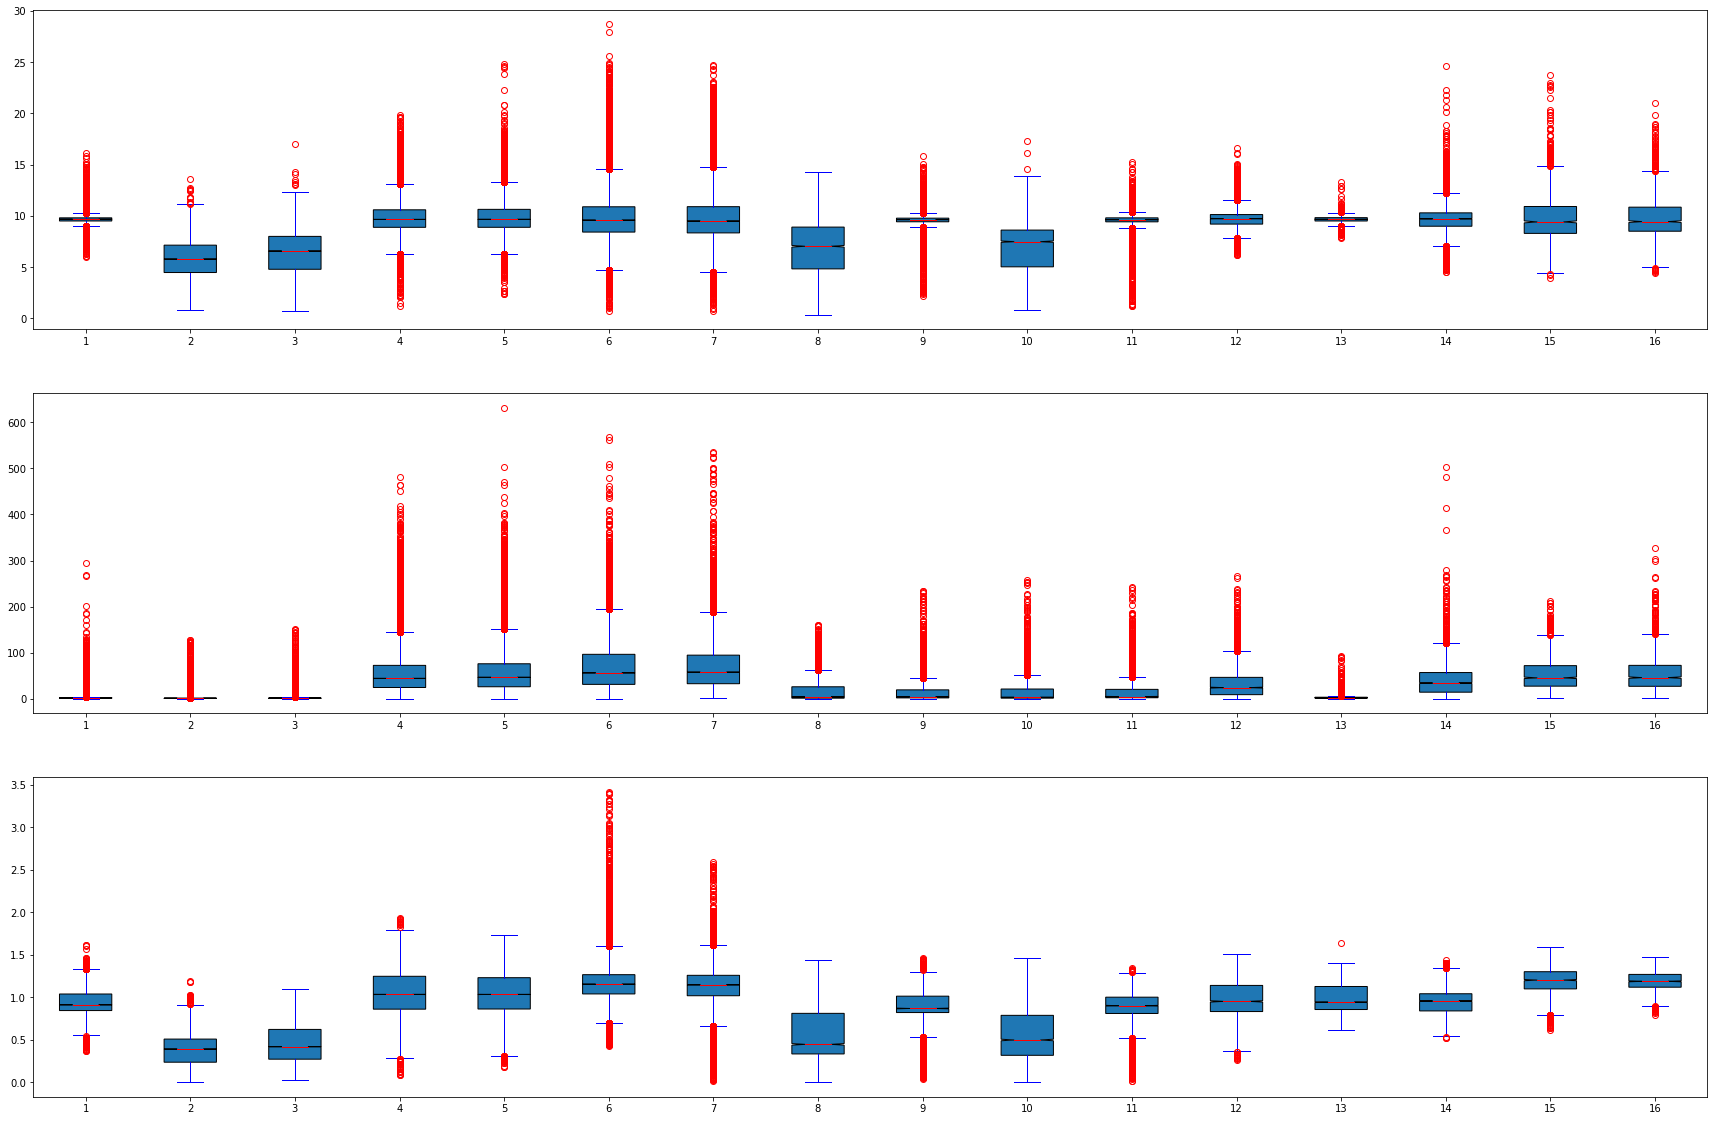

In [16]:

# act1 = t_acc[array[:,-1]==5]
activities = np.arange(1, 17) 
box_acc = [] # TODO ver se dá para fazer isto com np.array
box_gyr = []
box_mag = []
for i in range(1,17):
    act = (array[:,-1]==i)
    #length = np.sum(act)
    box_acc.append(t_acc[act]) 
    box_gyr.append(t_gyr[act])
    box_mag.append(t_mag[act])

c = "blue"
fig, axs = plt.subplots(3)
axs[0].boxplot(box_acc, notch=True, patch_artist=True,
            capprops=dict(color="blue"),
            whiskerprops=dict(color="blue"),
            flierprops=dict(color="red", markeredgecolor="red"),
            medianprops=dict(color="red"))
axs[1].boxplot(box_gyr, notch=True, patch_artist=True,
            capprops=dict(color="blue"),
            whiskerprops=dict(color="blue"),
            flierprops=dict(color="red", markeredgecolor="red"),
            medianprops=dict(color="red"))
axs[2].boxplot(box_mag, notch=True, patch_artist=True,
            capprops=dict(color="blue"),
            whiskerprops=dict(color="blue"),
            flierprops=dict(color="red", markeredgecolor="red"),
            medianprops=dict(color="red"))
plt.rcParams['figure.figsize'] = [30, 20]
plt.show()

## 3.2 Densidade de outliers

<Figure size 2160x1440 with 0 Axes>

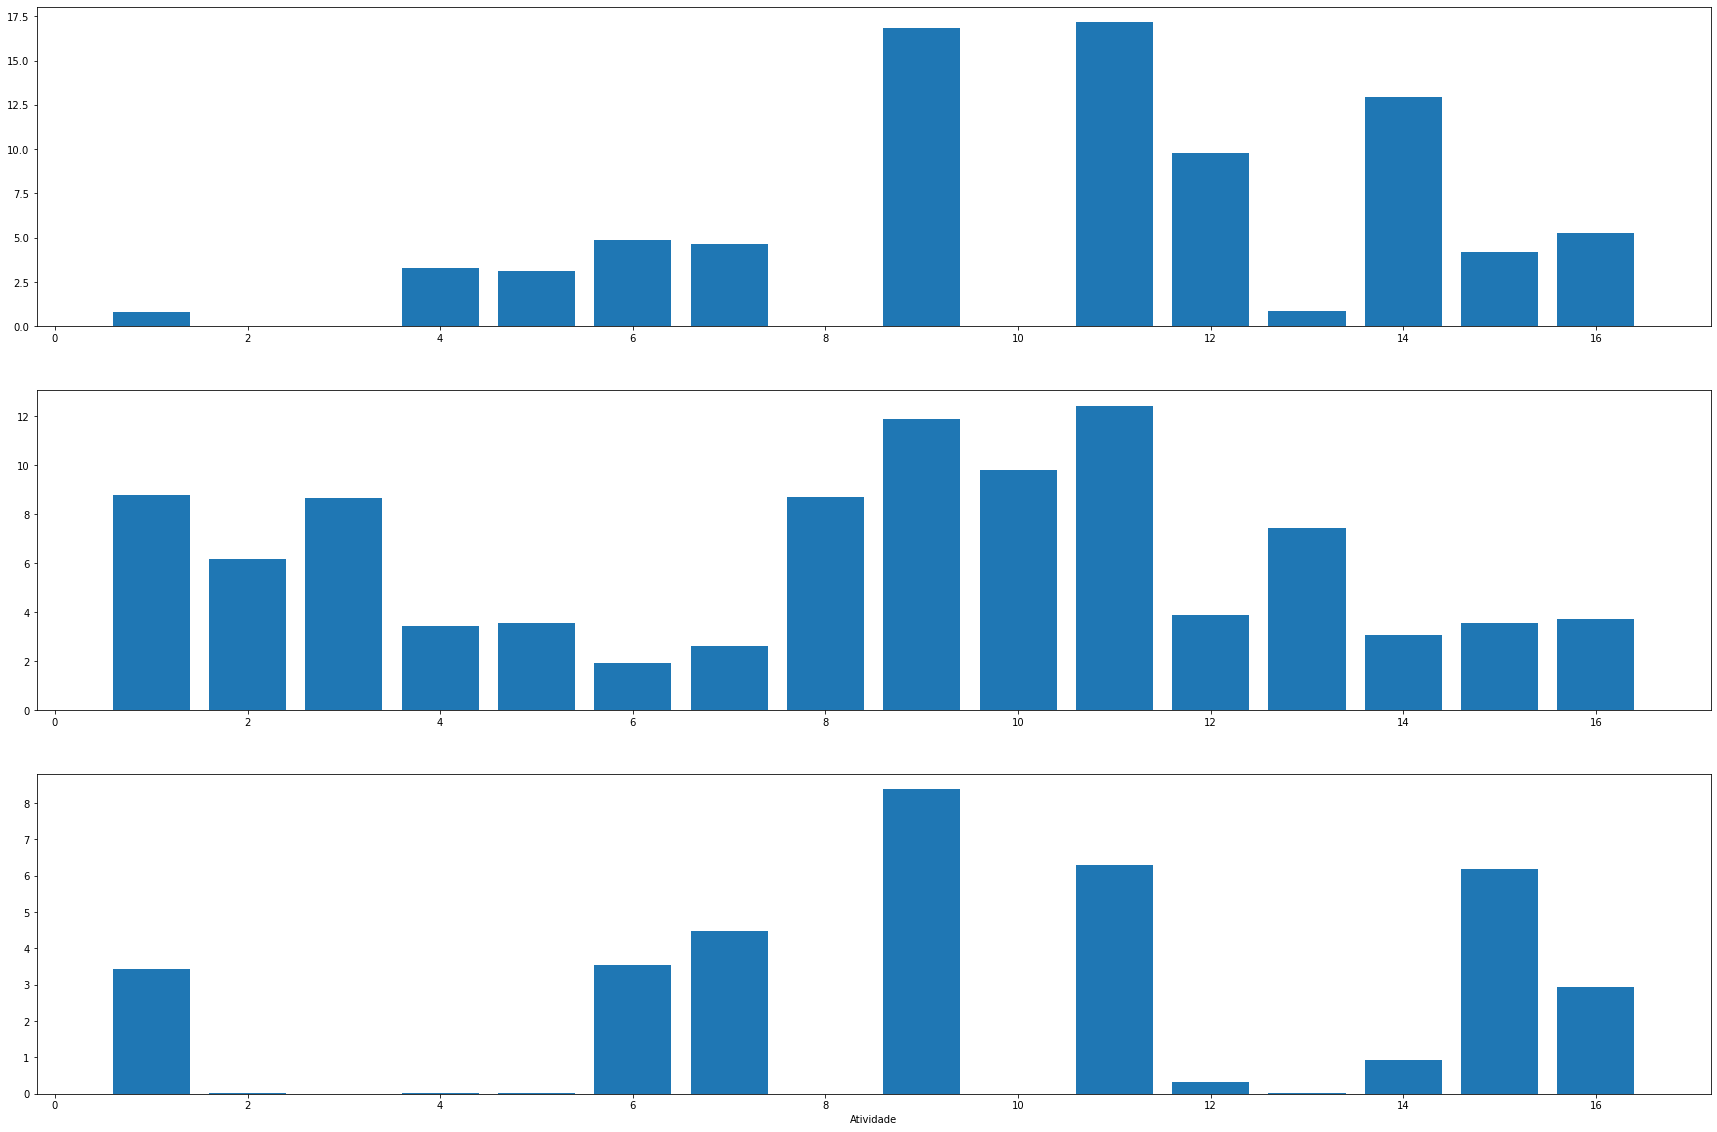

In [19]:
# desvio e outliers para cada k = 3, 3.5, 4
d = np.empty(shape=[3,16])
outliers = []
it = 0

# iterar pelos modulos e, depois, por cada atividade
for box in ([box_acc, box_gyr, box_mag]):
    
    for i in range(16):
        # computar os quartis e definir os limites
        q1 = np.quantile(box[:][i], 0.25)
        q3 = np.quantile(box[:][i], 0.75)
        iqr = q3-q1 
        upper_bound = q3+(1.5*iqr)
        lower_bound = q1-(1.5*iqr)

        # receber os outliers e a matrix de indices
        outliers.append(box[:][i][(box[:][i] < lower_bound) | (box[:][i] > upper_bound)])
        out_bool = (box[:][i] <= lower_bound) | (box[:][i] >= upper_bound)
        
        # densidade de outliers
        counts = np.count_nonzero(out_bool==True)
        d[it][i] = (counts/out_bool.size)*100 
    it+=1

xticks = np.linspace(1, 16, 16, endpoint=True)
plt.figure()
fig, axs = plt.subplots(3)
axs[0].bar(xticks, d[0])
axs[1].bar(xticks, d[1])
axs[2].bar(xticks, d[2])
plt.xlabel('Atividade')
plt.show()


Com uma análise superficial, rapidamente observa-se um pico claro em cada um dos módulos, em específico nas atividades 1, 2 e 1 de novo, respetivamente.

**TODO**

## 3.3 Função Z-score

In [20]:
def zscore(scores, k, axis=0):
    a = np.asanyarray(scores)
    if a.size == 0:
        return np.empty(a.shape)
    
    mn = np.mean(a, axis = axis)
    std = np.std(a, axis = axis)
    
    z = (scores - mn) / std
    outliers = scores[(z < -k) | (z > k)]
    
    return z, outliers


## 3.4 Teste de Z-score

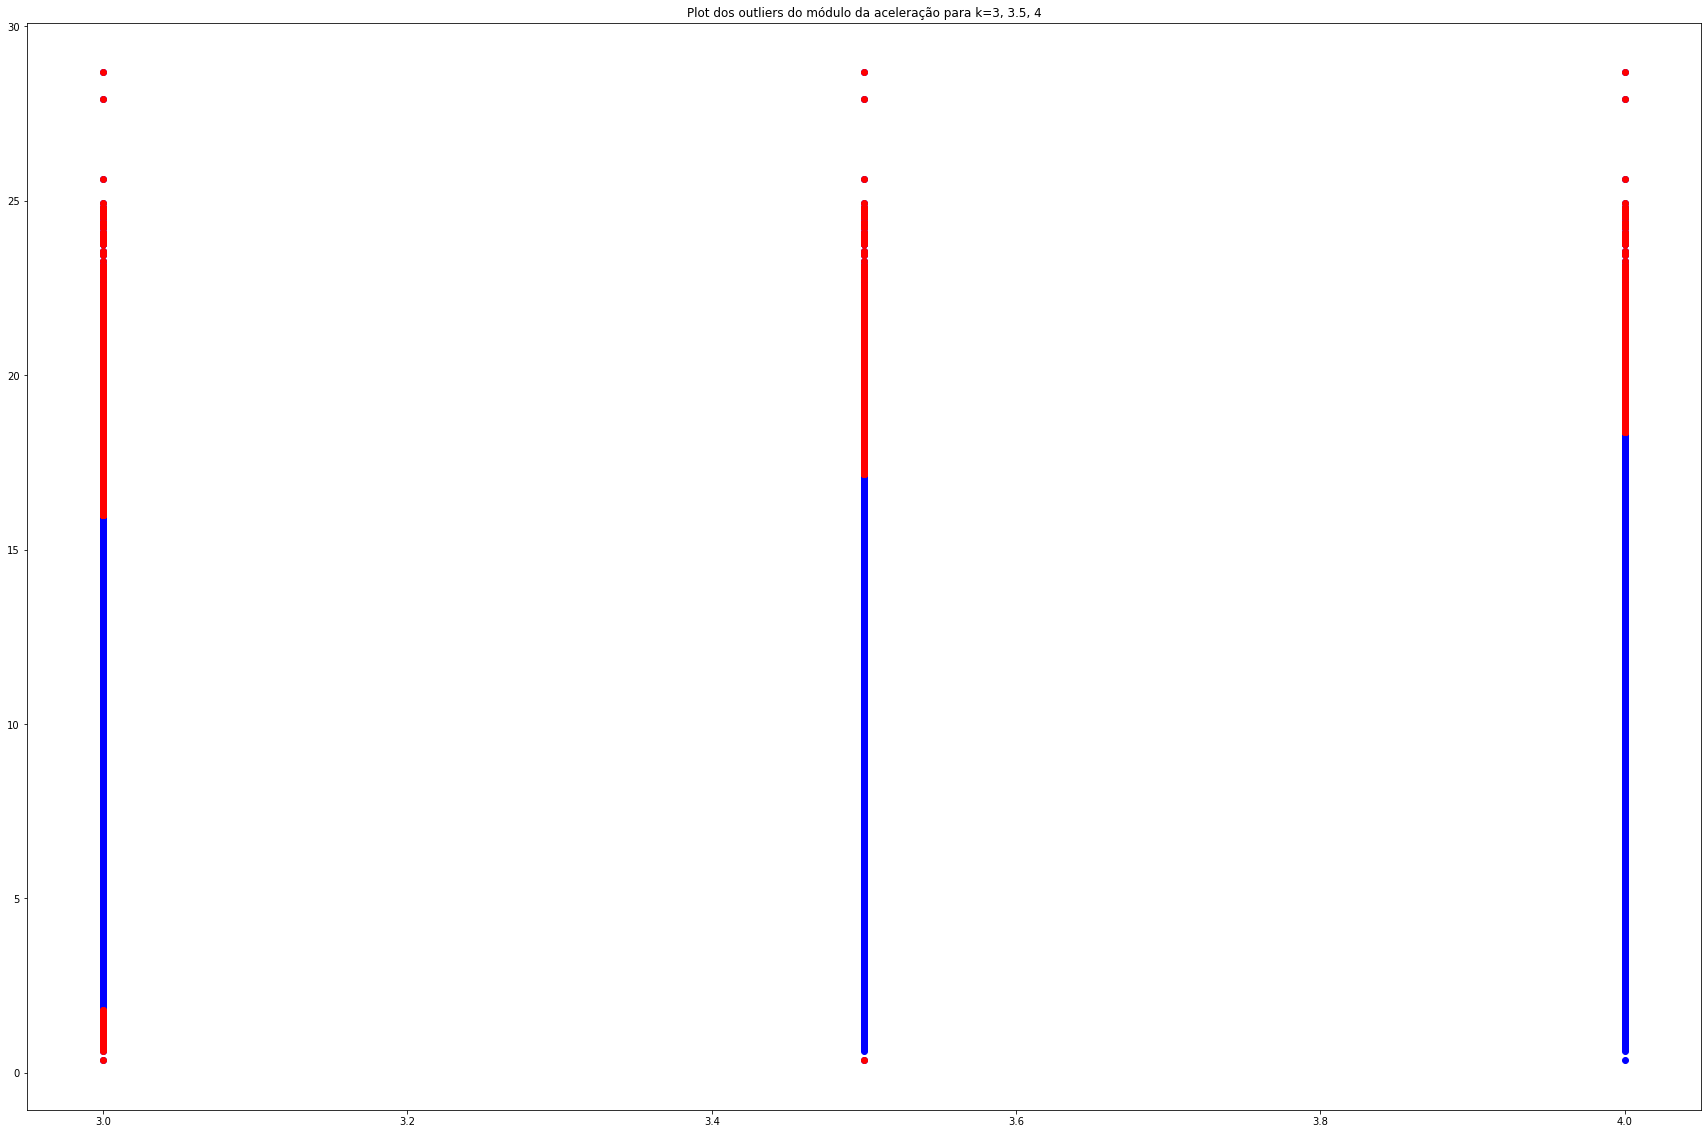

In [21]:
outliersk = []

for mod in [t_acc, t_gyr, t_mag]:
    z1, out1 = zscore(mod, 3)
    z2, out2 = zscore(mod, 3.5)
    z3, out3 =zscore(mod, 4)
    outliersk.append(out1)
    outliersk.append(out2)
    outliersk.append(out3)

plt.figure()
plt.scatter(np.ones(t_acc.shape)*3, t_acc, color="blue")
plt.scatter(np.ones(outliersk[0].shape)*3, outliersk[0], color="red")
plt.scatter(np.ones(t_acc.shape)*3.5, t_acc, color="blue")
plt.scatter(np.ones(outliersk[1].shape)*3.5, outliersk[1], color="red")
plt.scatter(np.ones(t_acc.shape)*4, t_acc, color="blue")
plt.scatter(np.ones(outliersk[2].shape)*4, outliersk[2], color="red")
plt.title('Plot dos outliers do módulo da aceleração para k=3, 3.5, 4')
plt.show()

## 3.5 Comparar os resultados dos dois métodos

In [22]:
diff = np.empty(shape=[3,3])

print("           boxplot  z-score")
print("k={}".format(0))
print("mod. acc: {} {}".format(np.hstack(outliers[0:16]).shape, outliersk[0].shape))
print("mod. gyr: {} {}".format(np.hstack(outliers[16:32]).shape, outliersk[3].shape))
print("mod. mag: {} {}".format(np.hstack(outliers[32:48]).shape, outliersk[6].shape))

print("k={}".format(1))
print("mod. acc: {} {}".format(np.hstack(outliers[0:16]).shape, outliersk[1].shape))
print("mod. gyr: {} {}".format(np.hstack(outliers[16:32]).shape, outliersk[4].shape))
print("mod. mag: {} {}".format(np.hstack(outliers[32:48]).shape, outliersk[7].shape))

print("k={}".format(2))
print("mod. acc: {} {}".format(np.hstack(outliers[0:16]).shape, outliersk[2].shape))
print("mod. gyr: {} {}".format(np.hstack(outliers[16:32]).shape, outliersk[5].shape))
print("mod. mag: {} {}".format(np.hstack(outliers[32:48]).shape, outliersk[8].shape))



           boxplot  z-score
k=0
mod. acc: (19740,) (9235,)
mod. gyr: (42314,) (12856,)
mod. mag: (11700,) (350,)
k=1
mod. acc: (19740,) (1598,)
mod. gyr: (42314,) (6874,)
mod. mag: (11700,) (220,)
k=2
mod. acc: (19740,) (787,)
mod. gyr: (42314,) (3705,)
mod. mag: (11700,) (167,)


A análise feita baseia-se na quantidade de outliers registados em cada módulo do sensor. Na análise se cada atividade somarou-se o número de ouliers em cada uma delas.

Verifica-se que o teste z-score retira muito menos outliers para cada um dos k testados (3, 3.5 e 4). 

## 3.6 Implementar o algoritmo Kmeans


In [23]:
from numpy.linalg import norm

def get_centroids(data, clusters):
    if type(data) != np.ndarray:
        data = np.array(data)
    rand_id = np.random.permutation(data.shape[0])
    centroids = data[rand_id[:(clusters)]] # cria 3 centroides para cada coluna
    return centroids

def get_distance(data, centroids, clusters):
    distance = np.zeros((data.shape[0], clusters))
    for i in range(clusters):
        row_norm = norm(data - centroids[i], axis=1)
        distance[:, i] = np.square(row_norm)
    return distance

def compute_centroids(data, clusters, distance):
    centroids = np.zeros((clusters, data.shape[1]))
    arr_min = np.argmin(distance, axis=1)
    for k in range(clusters):
        centroids[k, :] = np.mean(data[arr_min == k], axis=0)
    return centroids

def k_means(data, clusters):
    '''
    accepts a np.array with shape (n, m) with m exists
    '''
    centroids = get_centroids(data, clusters)
    diff = 1
    while diff!=0:
        old_centroids = centroids
        distance = get_distance(data, old_centroids, clusters)
        centroids = compute_centroids(data, clusters, distance)
        diff = np.sum(np.subtract(centroids, old_centroids))
        dist = get_distance(data, centroids, clusters)
        cluster = np.argmin(dist, axis=1)
    return centroids, cluster



## 3.7 Outliers segundo Kmeans

In [24]:
from scipy.spatial.distance import cdist

K = range(1, 10)
distortions = []
clusters = []

for k in K:
    #kmeanModel = KMeans(n_clusters=k).fit(X)
    centroids, cluster = k_means(array[:,1:10], k)
    distortions.append(sum(np.min(cdist(array[:,1:10], centroids, 'euclidean'), axis=1)) / array[:,1:10].shape[0])
    clusters.append(cluster)
# TODO clusters é unidimensional e não devia    


KeyboardInterrupt: 

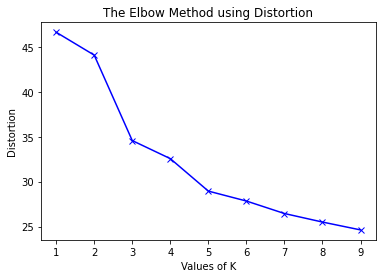

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


Do "gráfico de cotovelo" retiramos que o melhor valor a utilizar será k=4. Deferimos este valor mesmo que a respresentação não seja a ideal.

TypeError: scatter() missing 1 required positional argument: 'ys'

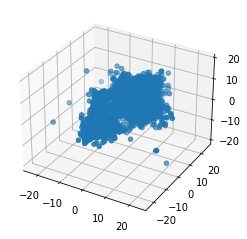

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(array[:,1], array[:,2], array[:,3])
ax.scatter3D(clusters[0:4])


## 3.8 Implementar x% de outliers (se x>d)

A primeira função dá os outliers segundo o boxplot e a sua densidade. A função substitui alguns dos pontos para prefazer x% outliers.

In [25]:
def get_outliers(vec):
    q1 = np.quantile(vec, 0.25)
    q3 = np.quantile(vec, 0.75)
    #av = np.average(vec)
    
    iqr = q3-q1
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)

    outliers = vec[(vec <= lower_bound) | (vec >= upper_bound)]
    out_bool = (vec <= lower_bound) | (vec >= upper_bound)
    
    counts = np.count_nonzero(out_bool==True)
    d = (counts/out_bool.size)*100
    return outliers, np.where(out_bool), d

def inject_outliers(x, d, data, shape):
    '''
    x - percentage of outliers wanted
    d - actual deviation
    data - data to be transformed
    shape - length of the data
    '''
    index = []
    if (x>d):
        points = round((x-d)*shape*0.01)
        median = np.median(data)
        sd = np.std(data)
        s = (np.random.random()*2)-1
        rang = np.ptp(data) # range
        for i in range(points):
            q = np.random.random()*rang
            point = round(np.random.random()*(data.shape[0])-1)
            index.append(point)
            data[point] = median+s*3*(sd+q)
    return data, index


## 3.9 Determinar o modelo linear a partir de uma amostra de treino

In [26]:
from sklearn import linear_model

def fit_linear(X, Y, n):
    '''
    X - train array (size p)
    Y - array to fit
    n - train size
    '''    
    reg = linear_model.LinearRegression()
    reg.fit(X[:n].reshape(-1,1), Y[:n])
    return reg.coef_

## 3.10 Injetar outliers e modelar linearmente

In [27]:
x = 10
t_out, t_ind, td = get_outliers(t_acc)
t_outliers, indexes = inject_outliers(x, td, t_acc.copy(), t_acc.shape[0])


In [28]:
from sklearn.model_selection import train_test_split
coef = []

n = t_acc.size    
ran = np.ptp(t_acc)
train = np.random.rand(n,2)*ran
train = np.append(train[:n], train[:n])

index = np.rint(np.hstack((t_ind[0], indexes))).astype(int)
    
coef = fit_linear(train, t_outliers, n)

t_outliers[index] = train[index]*coef
print(index)
print(t_acc[2609], t_outliers[2609])
# TODO ver se isto esta bem

[  2609   2611   2612 ... 778739 778776 778777]
12.862464513459308 0.0018107554147639893


# 4. Extração de informação caraterística

[Implementing Feature Selection Methods for ML](https://ranasinghiitkgp.medium.com/implementing-feature-selection-methods-for-machine-learning-bfa2e4b4e02)

## 4.1 Significância e gaussianidade

[ver link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2881615/)

In [29]:
from scipy import stats

mean = []
ks_test = []

for box in ([box_acc, box_gyr, box_mag]):
    for i in range(16):
        mean.append(np.mean(box[:][i]))
        ks_test.append(stats.kstest(box[:][i], 'norm'))


## 4.2 Extração de *features* relevantes

No artigo em causa, as features estatísticas direcionam-se apenas a cada eixo do acelerómetro e do giroscópio (colunas 1-7)

Damos também uso à estratégia 'sliding window' para atuar em todo o array de forma contínua

In [30]:
time = array[:,-2]
delta_time = time[1] - time[0]
deci = (2/0.60)*1000
window = math.floor(deci/delta_time)
print("window length: {}".format(window))

window length: 170


Não se realizam os testes de 'Pairwise Correlation', 'Averaged Velocity along HEading Direction' e de 'Averaged Velocity along Gravity Direction' devido à dificuldade de buscar os valores pretendidos para os cálculos

In [31]:
###########################
def eva(array, window):
    eva=[]
    for i in range(round(array.shape[0]/window)):
        i*=window
        cov = (np.cov(array[i:(i+window)]))
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        eva.append(eigenvectors)
    return np.array(eva).reshape([-1,1])

eva = eva(array[:,1:4], window) # acceleration axis
eva.shape

(4599, 1)

In [32]:
# acceleroemeter and gyroscope
mean = featuresFunctions.mean(array[:,1:7], window)
median = featuresFunctions.median(array[:,1:7], window)
std, var = featuresFunctions.std_var(array[:,1:7], window)
rms = featuresFunctions.rms(array[:,1:7], window)
skew = featuresFunctions.skewness(array[:,1:7], window)
kurt = featuresFunctions.kurtosis(array[:,1:7], window)
irange = featuresFunctions.irange(array[:,1:7], window)
zcr = featuresFunctions.zero_crossing_rate(array[:,1:7], window)
mcr = featuresFunctions.mean_crossing_rate(array[:,1:7], window)
se = featuresFunctions.spectral_entropy(array[:,1:7], window)

ai, vi = featuresFunctions.mov_intensity(array[:,1:4], window) # acceleration axis
sma = featuresFunctions.sma(array[:,1:4], window) # acceleration axis
eva = featuresFunctions.eva(array[:,1:4], window) # acceleration axis
cagh = featuresFunctions.cagh(array[:,2], array[:,3], array[:,1], window) # acceleration axis
domf, ener, aae, are = featuresFunctions.df_energy_aae_are(array[:,1:7], window) # each axis


feat_array = np.concatenate((mean, median, std, var, rms, irange,\
    zcr, mcr, se, ai, vi, sma, eva, cagh, domf, ener, aae, are), axis=1)

print(feat_array.shape)

In [ ]:
print((mean.shape, median.shape, std.shape, var.shape, rms.shape, irange.shape,\
    zcr.shape, mcr.shape, se.shape, ai.shape, vi.shape, sma.shape, eva.shape, cagh.shape, domf.shape))

((4599, 6), (4599, 6), (4599, 6), (4599, 6), (4599, 6), (4599, 6), (4599, 1), (4599, 1), (4599, 1), (4599, 1), (4599, 1), (4599, 1), (4599,), (4599, 1), (4599, 1))


Ajustar as atividades ao shape[0] do novo feat_array. Isto é feito através da extração da atividade predominante em cada *window*.

In [ ]:
feat_act = []
act = array[:,-1]

for i in range(round(act.shape[0]/window)):
    i*=window
    unique, counts = np.unique(act[i:(i+window)], return_counts=True)
    feat_act.append(unique[np.argmax(unique)])

len(feat_act)

Receber o vetor feature em qualquer instante. Lança um erro de índice se o fornecido não for real.

In [ ]:
def get_feat_vec(ind):
    try:
        return feat_array[ind,:]
    except IndexError:
        return np.empty()

## 4.3 PCA

PCA - identifica os eixos principais de variância do *dataset*. Permite explorar as variáveis chave e descobrir outliers

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def pca_feature(x, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state=0)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    pca = PCA()
    transformed_train = pca.fit_transform(X_train)
    transformed_test = pca.transform(X_test)

    return transformed_train, transformed_test, pca.explained_variance_ratio_, pca.singular_values_


## 4.4 Vetores principais

A partir do teste do PCA, obtemos os pesos de cada eixo principal do *dataset*, dos quais podemos inferir qual a sua relevância para 

Normalização é feita ao implementar o z-score, que devolve uma matriz com média zero e desvio padrão 0.

In [ ]:
x, out = zscore(feat_array, 1.5)
y, out = zscore(feat_act, 1.5)

t_train, t_test, ratio, sing = pca_feature(x, y, 0.5)

print(ratio, sing)

n_feat = 0
sum = 0
for score in ratio:
    if sum<0.75:
        n_feat+=1
        sum+=score
    else:
        break


NameError: name 'feat_array' is not defined

### 4.4.1 Como obter as features relativas à compressão 

### 4.4.2 Vantages e limitações

## 4.5 Implementar o Fisher Score e ReliefF

In [ ]:
from skfeature.function.similarity_based import fisher_score 

def f_score(x, y):
    ranks = fisher_score.fisher_score(x, y)
    return fisher_score.feature_rating

f_score(feat_array, feat_act)

In [ ]:
from ReliefF import ReliefF

def relief(x, y, neighbours, feat):
      
      fs = ReliefF(n_neighbors=neighbours, n_features_to_keep=feat)
      X_train = fs.fit_transform(x, y)
      return X_train, fs.score

X_train, relief_score = relief(feat_array, y, 5, 10)
print("(No. of tuples, No. of Columns before ReliefF) : "+str(feat_array.shape)+
      "\n(No. of tuples , No. of Columns after ReliefF) : "+str(X_train.shape))


## 4.6 Identificar as 10 melhores features

In [ ]:

# TODO verificar isto, comparar com o z-score, plotar (acc, gyr, mag)
n = 9
cluster = []

for box in ([box_acc, box_gyr, box_mag]):
    for k in range(1,n):
        for col in range(16):
            t = np.asanyarray(box[:][col]).reshape(-1,1)
            centroids, clusters = k_means(t, k)
            cluster.append(clusters)

